In [16]:
from torchvision.datasets import ImageFolder
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import seaborn as sns

In [2]:
from Data_Loader import *
from Generator import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_channels = 3
image_shape = (640,480)
batch_size = 2

In [4]:
device

device(type='cuda')

In [5]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])
dataset = ImageFolder('data/Spectogram/English',transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset into train and test subsets
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)
classes = dataset.classes
num_emotions = len(classes)
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, num_emotions)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
for name, param in model.named_parameters():
    if param.requires_grad and 'fc' not in name:
        param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/cilab/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
99.5%

# Training on the real data

In [6]:
def train_model():
  acc_valid = []
  acc_train = []
  num_epochs = 13   #(set no of epochs)
  start_time = time.time() #(for showing time)
  for epoch in range(num_epochs): #(loop for every epoch)
      print("Epoch {} running".format(epoch)) #(printing message)
      """ Training Phase """
      model.train()    #(training model)
      running_loss = 0.   #(set loss 0)
      running_corrects = 0
      # load a batch data of images
      
          #tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
      for inputs, labels in train_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              # forward inputs and get output
              optimizer.zero_grad()
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              # get loss value and update the network weights
              loss.backward()
              optimizer.step()
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
              #tepoch.set_postfix(loss=loss.item())
      # epoch_loss = running_loss / len(train_data)
      # epoch_acc = running_corrects / len(train_data) * 100.
      # acc_train.append(epoch_acc)
      #print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

      with torch.no_grad():
          running_loss = 0.
          running_corrects = 0
          for inputs, labels in test_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(test_set)
          epoch_acc = running_corrects / len(test_set) * 100.
          acc_valid.append(epoch_acc)
          print('[Valid #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

train_model()

Epoch 0 running
[Valid #0] Loss: 1.0472 Acc: 67.9283% Time: 28.6487s
Epoch 1 running
[Valid #1] Loss: 0.7906 Acc: 76.4940% Time: 48.3766s
Epoch 2 running
[Valid #2] Loss: 0.6619 Acc: 82.0717% Time: 68.0695s
Epoch 3 running
[Valid #3] Loss: 0.6118 Acc: 82.4701% Time: 87.7187s
Epoch 4 running
[Valid #4] Loss: 0.5466 Acc: 82.8685% Time: 107.4187s
Epoch 5 running
[Valid #5] Loss: 0.5222 Acc: 83.2669% Time: 127.0681s
Epoch 6 running
[Valid #6] Loss: 0.4949 Acc: 84.0637% Time: 146.6747s
Epoch 7 running
[Valid #7] Loss: 0.4907 Acc: 83.4661% Time: 166.4746s
Epoch 8 running
[Valid #8] Loss: 0.4555 Acc: 85.8566% Time: 186.1246s
Epoch 9 running
[Valid #9] Loss: 0.4044 Acc: 88.2470% Time: 205.8187s
Epoch 10 running
[Valid #10] Loss: 0.4576 Acc: 82.4701% Time: 225.6691s
Epoch 11 running
[Valid #11] Loss: 0.4233 Acc: 86.2550% Time: 245.2817s
Epoch 12 running
[Valid #12] Loss: 0.4147 Acc: 84.6614% Time: 264.8819s


In [7]:
import os
import shutil
def remove_all_directories(directory):
    for item in os.listdir(directory):
        item_path = os.path.join(directory, item)

        if os.path.isdir(item_path):
            shutil.rmtree(item_path)

In [13]:
def load_model(emotion,path='Gan_Results/Models'):
    path_tmp = f'{path}/{emotion}'
    remove_all_directories(path_tmp)

    model_path = os.listdir(path_tmp)[0]
    model_path = f'{path_tmp}/{model_path}'

    gen = Generator(n_channels, n_channels).to(device)
    gen.load_state_dict(torch.load(model_path, map_location=torch.device(device))["gen_AB"])
    return gen


# Evaluating the model on the real and fake data

In [20]:
import numpy as np

def calculate_accuracy(conf_matrix):
    diagonal_sum = np.trace(conf_matrix)  # Sum of diagonal elements
    total_sum = np.sum(conf_matrix)       # Total number of samples

    accuracy = diagonal_sum / total_sum   # Calculate accuracy

    return accuracy

In [26]:
from sklearn.metrics import confusion_matrix
predictions = []
true_labels = []
fake_predictions = []
Emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Generators = []
for i,emotion in enumerate(Emotions):
    Generators.append(load_model(emotion))

with torch.no_grad():
  for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      tmp = []
      for i in range(inputs.shape[0]):
        fake_image = inputs[i]
        #print(fake_image.shape)
        fake_image = Generators[labels.data[i].item()](fake_image)
        tmp.append(fake_image)
      fake_image = torch.stack(tmp, dim=0)
      fake_outputs = model(fake_image)
      _, fake_predicted = torch.max(fake_outputs, 1)
      fake_predictions.extend(fake_predicted.tolist())

      #fake_image = Generators(get_noise(len(real_image), n_channels,image_shape, device='cuda'))
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      predictions.extend(predicted.tolist())
      true_labels.extend(labels.tolist())


### The Confusion Matrix on Real data

The accuracy is : 84.66135458167331%


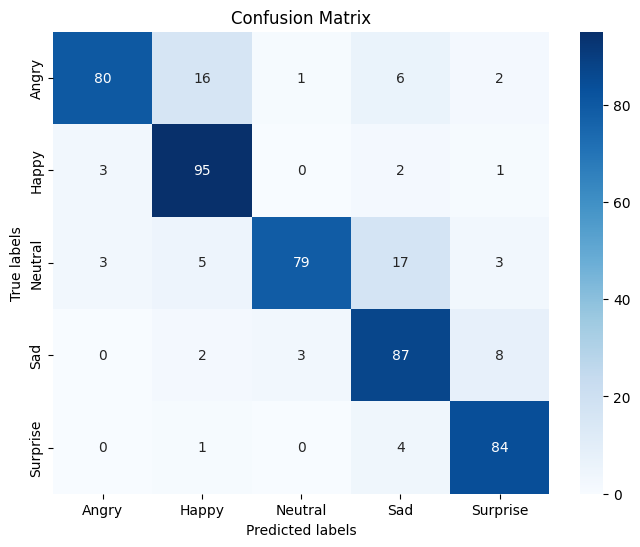

In [27]:
conf_matrix = confusion_matrix(true_labels, predictions)
print(f'The accuracy is : {calculate_accuracy(conf_matrix)*100}%')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)
plt.yticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)

plt.show()

### The Confusion Matrix on Synthesized data

The accuracy is : 70.91633466135458%


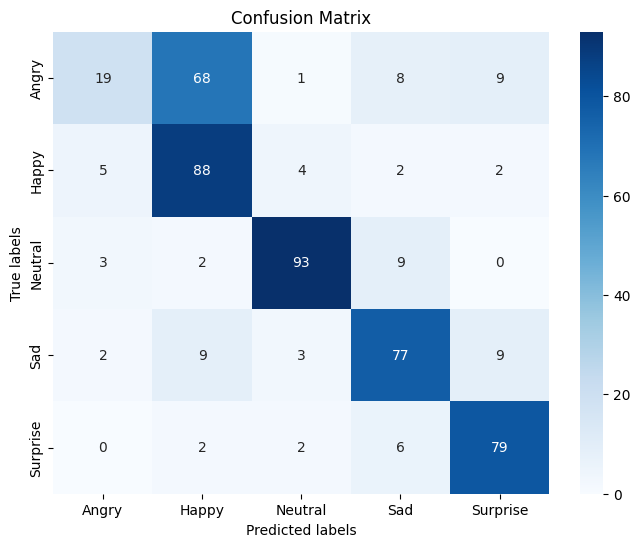

In [28]:
conf_matrix = confusion_matrix(true_labels, fake_predictions)
print(f'The accuracy is : {calculate_accuracy(conf_matrix)*100}%')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)
plt.yticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)

plt.show()

In [29]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, shuffle=False)

# Training on the real and fake data

In [40]:
def train_model_sythesized():
  acc_valid = []
  acc_train = []
  num_epochs = 5   #(set no of epochs)
  start_time = time.time() #(for showing time)
  Emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
  Generators = []
  for i,emotion in enumerate(Emotions):
    Generators.append(load_model(emotion))

  for epoch in range(num_epochs): #(loop for every epoch)
      print("Epoch {} running".format(epoch)) #(printing message)
      """ Training Phase """
      model.train()    #(training model)
      running_loss = 0.   #(set loss 0)
      running_corrects = 0
      # load a batch data of images
      #with tqdm(train_loader,unit="batch") as tepoch:
         # tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
      for inputs, labels in train_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)


              #generating fake images
              tmp = []
              for i in range(inputs.shape[0]):
                    fake_image = inputs[i]
                    #print(fake_image.shape)
                    fake_image = Generators[labels.data[i].item()](fake_image)
                    tmp.append(fake_image)

              tmp = torch.stack(tmp,dim=0)
              inputs = torch.cat((inputs,tmp))
              labels = torch.cat((labels,labels))

              # forward inputs and get output
              optimizer.zero_grad()
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              # get loss value and update the network weights
              loss.backward()
              optimizer.step()
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)
              #tepoch.set_postfix(loss=loss.item())
      # epoch_loss = running_loss / len(train_data)
      # epoch_acc = running_corrects / len(train_data) * 100.
      # acc_train.append(epoch_acc)
      #print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

      with torch.no_grad():
          running_loss = 0.
          running_corrects = 0
          for inputs, labels in test_loader:
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)
              running_loss += loss.item() * inputs.size(0)
              running_corrects += torch.sum(preds == labels.data)

          epoch_loss = running_loss / len(test_set)
          epoch_acc = running_corrects / len(test_set) * 100.
          acc_valid.append(epoch_acc)
          print('[Valid #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time()- start_time))

train_model_sythesized()

Epoch 0 running
[Valid #0] Loss: 0.4943 Acc: 80.6773% Time: 54.7039s
Epoch 1 running
[Valid #1] Loss: 0.5123 Acc: 79.4821% Time: 109.0961s
Epoch 2 running
[Valid #2] Loss: 0.4847 Acc: 83.2669% Time: 163.5097s
Epoch 3 running
[Valid #3] Loss: 0.4717 Acc: 81.4741% Time: 218.1105s
Epoch 4 running
[Valid #4] Loss: 0.5100 Acc: 79.8805% Time: 272.5924s


In [41]:
from sklearn.metrics import confusion_matrix
predictions = []
true_labels = []
fake_predictions = []
Emotions = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
Generators = []
for i,emotion in enumerate(Emotions):
    Generators.append(load_model(emotion))

with torch.no_grad():
  for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      tmp = []
      for i in range(inputs.shape[0]):
        fake_image = inputs[i]
        #print(fake_image.shape)
        fake_image = Generators[labels.data[i].item()](fake_image)
        tmp.append(fake_image)
      fake_image = torch.stack(tmp, dim=0)
      fake_outputs = model(fake_image)
      _, fake_predicted = torch.max(fake_outputs, 1)
      fake_predictions.extend(fake_predicted.tolist())

      #fake_image = Generators(get_noise(len(real_image), n_channels,image_shape, device='cuda'))
      outputs = model(inputs)
      _, predicted = torch.max(outputs, 1)
      predictions.extend(predicted.tolist())
      true_labels.extend(labels.tolist())

The accuracy is : 79.8804780876494%


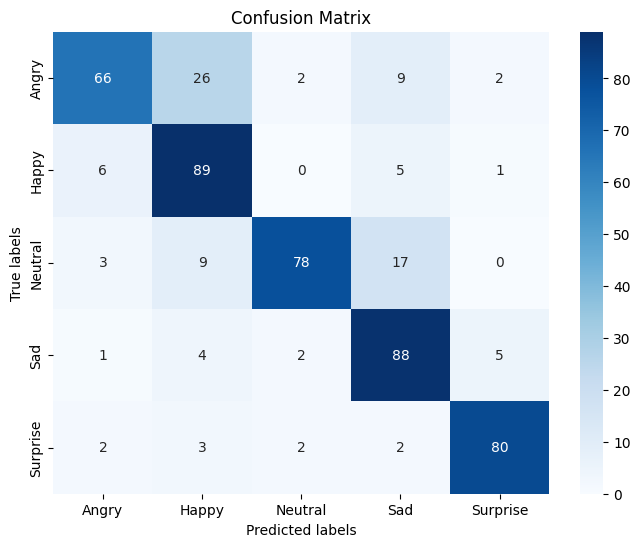

In [43]:
conf_matrix = confusion_matrix(true_labels, predictions)
print(f'The accuracy is : {calculate_accuracy(conf_matrix)*100}%')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')

plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.xticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)
plt.yticks(ticks=np.arange(len(dataset.classes)) + 0.5, labels=dataset.classes)

plt.show()